
# Polygon Extractor Using the Copernicus Marine Toolbox

## Introduction

This guide explains how to extract Copernicus Marine data within the boundaries of a polygon provided in a vector file format such as ``.geojson``, ``.shp``, ``.gpkg``, or ``.kml``.
By using the geometry of the polygon, the dataset is spatially subsetted to retain only the relevant area.

In this example, we focus on the French coastline, and illustrate how to download and process the eastward (``uo``) and northward (``vo``) sea water velocity variables using the product [GLOBAL_ANALYSISFORECAST_PHY_001_024](https://data.marine.copernicus.eu/product/GLOBAL_ANALYSISFORECAST_PHY_001_024/description), specifically the dataset ``cmems_mod_glo_phy_anfc_0.083deg_P1D-m``.

## Import the required libraries

We start by importing all necessary libraries to read vector files, handle NetCDF data, perform clipping, and visualize the data.

| Module name | Description |
| :---: | :---|
|**Copernicus Marine Toolbox**| [Copernicus Marine Toolbox](https://toolbox-docs.marine.copernicus.eu/en/v2.0.1/) facilitates access, analysis, and visualization of Copernicus Marine data.|
|**geopandas**| [GeoPandas](https://geopandas.org/en/stable/) is a powerful package for working with geospatial data in tabular form.|
|**xarray**| [Xarray](http://xarray.pydata.org/en/stable/) is a very user friendly library to manipulate NetCDF files within Python. It introduces labels in the form of dimensions, coordinates and attributes.| 
| **netCDF4** | [netCDF4](https://unidata.github.io/netcdf4-python/) is a Python interface to the netCDF C library.|
|**rioxarray**| [rioxarray](https://corteva.github.io/rioxarray/stable/) enables geospatial raster operations in xarray.|
|**matplotlib**| [matplotlib](https://matplotlib.org/) is a library for creating static, animated, and interactive visualizations in Python.|

📝 Note: Make sure the file ``functions_polygons.py`` is present in the same directory as your script.
It contains all the utility functions required for the workflow described here. \
You can find the file in the [Git repository](https://github.com/mercator-ocean/copernicus-marine-toolbox/tree/main/doc/usage), but you can also download it directly from [this link](https://atlas.mercator-ocean.fr/s/KHi5GiLy47C8k5k).

In [ ]:
import os 
from copernicusmarine import open_dataset
import geopandas as gpd
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt


from functions_polygons import extract_clipped_dataset

## Load polygon, extract data and apply spatial clip  

In this step, we call the function ``extract_clipped_dataset`` defined in `functions_polygons.py` to load the polygon file, extract the corresponding Copernicus Marine data for the specified variables, time range, and depth range, and apply the polygon as a spatial clip.

Note: If this is your first time using the ``copernicusmarine`` package, you will be prompted to insert your Copernicus Marine username and password ([request yours here, it's free](https://help.marine.copernicus.eu/en/articles/4220332-how-to-sign-up-for-copernicus-marine-service)). If you want to avoid entering your credentials every time, we recommend following [this guide](https://help.marine.copernicus.eu/en/articles/7949409-copernicus-marine-toolbox-introduction#h_9172b5c79a) to save them.

#### 🔹 Steps of the ``extract_clipped_dataset`` function:

1. Loads a polygon file and extracts its **minimum bounding box**.
2. Downloads a **subset of data** from the Copernicus Marine dataset within the bounding box using the Toolbox.
3. **Creates a clip** from the provided polygons and applies it to the dataset.
4. Returns the result as an ``xarray.Dataset``. If ``OUTPUT_FILE`` is provided, it also encodes and saves the dataset as a NetCDF (``.nc``) file.

#### 🔹 Parameters:

1. **`polygon_file`** (*str*): Path to the file containing the polygons (e.g. ``.geojson``, ``.shp``, ``.gpkg``, or ``.kml``).
2. **`dataset_id`** (*str*): Copernicus Marine dataset ID to download.  
3. **`variables`** (*list*): List of variables to extract.  
4. **`start_date`** (*str*): Start date (format `YYYY-MM-DD`).  
5. **`end_date`** (*str*): End date (format `YYYY-MM-DD`).  
6. **`min_depth`** (*float, optional*): Minimum depth (in meters), set to None to disable.  
7. **`max_depth`** (*float, optional*): Maximum depth (in meters), set to None to disable.  
8. **`output_file`** (*str, optional*): Output file name to save the clipped dataset, set to None to disable.

#### 🔹 Returns:
- **`clipped_data`** (*xarray.Dataset*):  
  - Returned the final result as an ``xarray.Dataset``, and if ``OUTPUT_FILE`` is set, it also saves it as a NetCDF (``.nc``) file.

In this example, we extract ocean current data (``uo``, ``vo``) along the French coastline between February 6 and 14, 2025, with a depth range limited to 0–100 meters. \
The file `french_coast.geojson` used below can be downloaded from the [Git repository](https://github.com/mercator-ocean/copernicus-marine-toolbox/tree/main/doc/usage)

In [3]:
clipped_data = extract_clipped_dataset(
    polygon_file="french_coast.geojson", # Path to the file containing the polygons  
    dataset_id='cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m', # Copernicus Marine dataset ID to download
    variables=['uo','vo'], # List of variables to extract  
    start_date='2025-02-06', #: Start date (format `YYYY-MM-DD
    end_date='2025-02-14', # End date (format `YYYY-MM-DD`)    
    min_depth=None, # Minimum depth (in meters), Set to None to disable.
    max_depth=100, # Maximum depth (in meters), Set to None to disable
    output_file="dataset_french_coast.nc" # Output file name to save the clipped dataset, Set to None to disable.
)

INFO - 2025-06-06T14:42:32Z - Selected dataset version: "202406"
INFO - 2025-06-06T14:42:32Z - Selected dataset part: "default"


Dataset successfully saved at: dataset_french_coast.nc
Dataset was successfully clipped and is ready for use.


## Visualize the clipped dataset (optional)

This step is **optional** and allows to **preview the clipped dataset**.  
It selects the first available variable, time and depth index (if applicable) and displays the data using a color map.  
This visualization helps verify that the clipping process has been applied correctly.

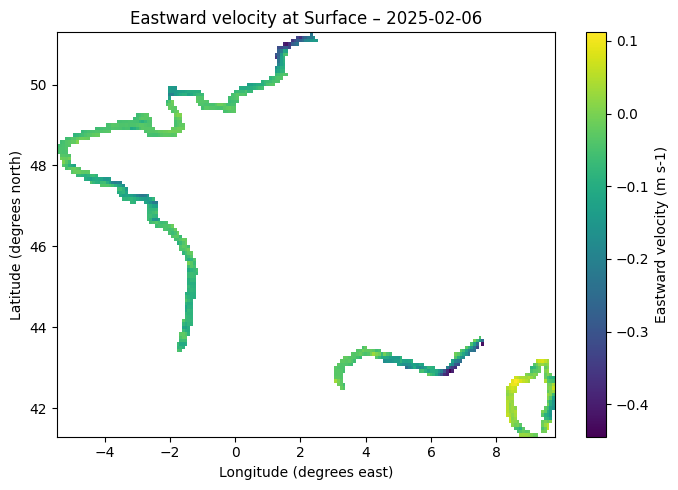

In [22]:
var_name = next(iter(clipped_data.data_vars))
da = clipped_data[var_name].isel(time=0, depth=0, missing_dims="ignore")

long_name = da.attrs.get("long_name", var_name)
units = da.attrs.get("units", "")
lat_units = clipped_data['latitude'].attrs.get("units", "")
lon_units = clipped_data['longitude'].attrs.get("units", "")

time = str(da.time.values)[:10] if "time" in da.coords else "N/A"
depth = round(da.depth.values.item(), 3)
depth_str = f"{depth} m" if depth != 0.494 else "Surface"

plt.figure(figsize=(7, 5))
plt.pcolormesh(da.longitude, da.latitude, da.values, shading='auto')
colorbar_label = f"{long_name} ({units})" if units else long_name
plt.colorbar(label=colorbar_label)
plt.title(f"{long_name} at {depth_str} – {time}", fontsize=12)
plt.xlabel(f"Longitude ({lon_units.replace('_', ' ')})")
plt.ylabel(f"Latitude ({lat_units.replace('_', ' ')})")
plt.gca().set_aspect('auto')
plt.tight_layout()
plt.show()


## Conclusion

You’ve now seen how to access and extract Copernicus Marine Service data over specific geographic regions by using polygon-based clipping, and how to visualize the resulting data effectively.

With these tools, you can load polygons from a vector file, apply spatial subsetting, and retrieve targeted data from Copernicus Marine datasets. Feel free to reuse or adapt any of the Python code provided to fit your own applications.

We’d love to hear your feedback on how we can improve it — whether it's about the topics, tools, clarity, pacing, or overall structure.  

If you have any questions, feel free to contact us through a chat session available in the bottom right corner of any [Copernicus Marine](https://marine.copernicus.eu/) webpage.